In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
# import sklearn.metrics import accuracy 
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
import torchsummary


In [2]:
(x_train,_), (x_test,_) = fashion_mnist.load_data()



In [3]:
x_train, x_test = x_train / 255.0, x_test/255.0
x_train.max()

1.0

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
x_train = np.reshape(x_train, (60000,28,28,1))
x_test = np.reshape(x_test, (10000,28,28,1))
x_train.shape

(60000, 28, 28, 1)

In [7]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
train_size = 1000
batch_size = 32
test_size = 1000

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(test_size).batch(batch_size)

In [10]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [11]:
class VAE(Model):

    def __init__(self, latent_dim):
        super(VAE,self).__init__()
        self.latent_dim = latent_dim
        # self.hidden_layer = hidden_layer

        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(28,28,1) ) ,
            layers.Conv2D(filters = 32, kernel_size= (3,3), strides=(2,2), padding='same' , activation='relu'),
            layers.MaxPool2D(pool_size= (2,2), strides= (2,2) ),
            layers.Conv2D(filters = 64, kernel_size= (3,3), strides=(2,2), padding='same' , activation='relu'),
            layers.MaxPool2D(pool_size= (2,2), strides= (2,2) ),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)

        ])

        self.decoder = tf.keras.Sequential([
            layers.InputLayer(  input_shape=(latent_dim,) ),
            layers.Dense(units = 7 *7*32, activation='relu'),
            layers.Reshape(target_shape=(7,7,32)),
            layers.Conv2DTranspose(filters=32, kernel_size= (3,3), strides = (1,1), padding= 'same', activation='relu' ),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=64, kernel_size= (3,3), strides = (1,1), padding= 'same', activation='relu' ),
            layers.UpSampling2D(size=(2,2)),
            # layers.Conv2DTranspose(filters=1, kernel_size= (3,3), strides = (1,1), padding= 'same', activation='sigmoid'),
            layers.Conv2DTranspose(filters=1, kernel_size= (3,3), strides = (1,1), padding= 'same'),
            

        ])


    def encode(self,x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis = 1)
        return mean, logvar
    
    def reparameterize(self,mean,logvar):
        eps = tf.random.normal(shape = mean.shape)
        return mean + eps* tf.exp(logvar * 0.5)
    
    def decode(self,z):
        out = self.decoder(z)
        return out


    def sample(self, eps = None):
        if eps is None:
            eps = tf.random.normal(shape = (100, self.latent_dim))

        return self.decode(eps)



    

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-3)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [13]:
epochs = 50
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

In [14]:
# model.summary()

In [15]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [16]:
# generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  # display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}'
        .format(epoch, elbo))
#   generate_and_save_images(model, epoch, test_sample)

Epoch: 1, Test set ELBO: -271.9333801269531
Epoch: 2, Test set ELBO: -269.3380432128906
Epoch: 3, Test set ELBO: -268.5915222167969
Epoch: 4, Test set ELBO: -266.9696350097656
Epoch: 5, Test set ELBO: -266.3743591308594
Epoch: 6, Test set ELBO: -266.4210510253906
Epoch: 7, Test set ELBO: -266.15203857421875
Epoch: 8, Test set ELBO: -265.05615234375
Epoch: 9, Test set ELBO: -266.0285339355469
Epoch: 10, Test set ELBO: -264.7662353515625
Epoch: 11, Test set ELBO: -264.8706970214844
Epoch: 12, Test set ELBO: -264.79351806640625
Epoch: 13, Test set ELBO: -263.9149169921875
Epoch: 14, Test set ELBO: -264.2061767578125
Epoch: 15, Test set ELBO: -264.3375549316406
Epoch: 16, Test set ELBO: -263.8731384277344
Epoch: 17, Test set ELBO: -263.91400146484375
Epoch: 18, Test set ELBO: -263.430908203125
Epoch: 19, Test set ELBO: -263.8680114746094
Epoch: 20, Test set ELBO: -263.5908203125
Epoch: 21, Test set ELBO: -263.4540100097656
Epoch: 22, Test set ELBO: -263.6430969238281
Epoch: 23, Test set EL

In [17]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

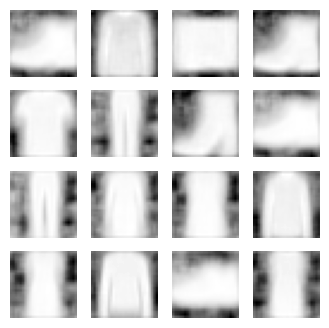

In [18]:
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
generate_and_save_images(model, 0, test_sample)